In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
file_path = './Datasets/DEMAND_DATA_SET_TEXAS_With_Density.xlsx'
df = pd.read_excel(file_path)
df.head()

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,season,...,Relative Humidity_SOUTH_C,Pressure_SOUTH_C,Wind Speed_SOUTH_C,Precipitable Water_SOUTH_C,Global Horizontal UV Irradiance (280-400nm)_SOUTH_C,Temperature_WEST,Relative Humidity_WEST,Pressure_WEST,Wind Speed_WEST,Precipitable Water_WEST
0,2009-01-01,175519.808224,26021.711251,27535.366659,17877.628770,230494.391858,46225.353768,109199.100739,20266.189296,3,...,43.28,952.25,3.72,0.65,8.36,7.43,47.15,939.00,3.77,0.61
1,2009-01-02,189629.545520,23552.501729,27269.110886,16670.843917,220268.870054,47260.666795,112714.269292,19884.627031,3,...,45.05,948.29,3.24,0.62,8.41,8.71,54.95,935.25,2.47,0.73
2,2009-01-03,191088.386304,23241.144180,26089.209623,15630.566651,211639.366540,50214.543906,110868.891577,18641.760463,3,...,44.91,946.13,3.86,0.89,8.32,11.45,44.89,932.79,3.60,0.64
3,2009-01-04,180221.173004,24210.469142,28855.279561,19514.066371,252293.903291,47977.462095,115478.773445,22657.413344,3,...,47.43,959.92,5.19,0.86,6.48,-0.17,46.15,948.56,4.99,0.83
4,2009-01-05,218879.805999,34147.205179,32089.849089,22909.295709,338502.536230,55588.637491,154291.272978,26876.941743,3,...,52.12,956.00,3.44,1.75,3.50,-0.22,48.40,942.79,2.80,1.10


In [3]:
data = df.iloc[:, list(range(14,21))]
data.head()

,Temperature_COAST,Relative Humidity_COAST,Pressure_COAST,Wind Speed_COAST,Density_COAST,Precipitable Water_COAST,Global Horizontal UV Irradiance (280-400nm)_COAST
0,12.75,83.03,1015.04,1.83,2.339398,2.32,4.96
1,18.57,90.13,1010.04,2.35,2.398862,2.57,4.90
2,20.64,87.43,1007.71,3.27,2.421479,2.95,8.16
3,17.47,84.13,1014.00,2.26,2.380479,2.83,6.45
4,8.15,78.61,1015.21,2.60,2.301353,3.58,1.67


In [4]:
train = data.iloc[:-365]  # Use the first 9 years for training
test = data.iloc[-365:]   # Use the last year for testing
train.head()

,Temperature_COAST,Relative Humidity_COAST,Pressure_COAST,Wind Speed_COAST,Density_COAST,Precipitable Water_COAST,Global Horizontal UV Irradiance (280-400nm)_COAST
0,12.75,83.03,1015.04,1.83,2.339398,2.32,4.96
1,18.57,90.13,1010.04,2.35,2.398862,2.57,4.90
2,20.64,87.43,1007.71,3.27,2.421479,2.95,8.16
3,17.47,84.13,1014.00,2.26,2.380479,2.83,6.45
4,8.15,78.61,1015.21,2.60,2.301353,3.58,1.67


In [5]:
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
x_tr = np.arange(train_scaled.shape[0]).reshape(-1,1)
#x_tr = scaler.fit_transform(x_tr)

test_scaled = scaler.transform(test)
x_te = np.arange(test_scaled.shape[0]).reshape(-1,1)
#x_te = scaler.fit_transform(x_te)
print(x_tr.shape, train_scaled.shape, x_te.shape, test_scaled.shape)

(4748, 1) (4748, 7) (365, 1) (365, 7)


In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps, :])
    return np.array(Xs), np.array(ys)

In [7]:
time_steps = 10 
X_train, y_train = create_dataset(x_tr, train_scaled, time_steps)
X_test, y_test = create_dataset(x_te, test_scaled, time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4738, 10, 1) (4738, 7) (355, 10, 1) (355, 7)


In [8]:
import tensorflow as tf
def density_loss(predictions):
    R = 8.31
    density_true = predictions[:, 2] / ((273 + predictions[:, 0]) * R)
    density_pred = predictions[:, -3]
    density_loss = tf.reduce_mean(tf.square(density_true - density_pred))
    return density_loss

def heat_constraint_loss(predictions):
    T_heat = 30.0
    T_i = predictions[:, 0]
    heat_loss = tf.reduce_mean(tf.square(tf.maximum(0.0, T_i - T_heat)))
    return heat_loss

def cool_constraint_loss(predictions):
    T_cool = -2.0
    T_i = predictions[:, 0]
    cool_loss = tf.reduce_mean(tf.square(tf.maximum(0.0, T_cool - T_i)))
    return cool_loss

def PINN_loss(y_true, y_pred):
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    a = 0.8
    b = 0.1
    # Define physics-based constraints
    heat_loss = heat_constraint_loss(y_pred)
    cool_loss = cool_constraint_loss(y_pred)
    den_loss = density_loss(y_pred)
    # Regularization parameters
    lambda_heat = 0.1
    lambda_cool = 0.1

    total_loss = a * data_loss + (1-a-b) * (lambda_heat * heat_loss + lambda_cool * cool_loss) + b * den_loss
    
    return total_loss

In [9]:
model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(7))  # 6 output features
model.compile(optimizer='adam', loss=PINN_loss)

In [12]:
data_collection = []
for x in range(1):
    model = Sequential()
    model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(7))  # 6 output features
    model.compile(optimizer='adam', loss=PINN_loss)
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)
    predictions_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)
    y_test_orig = scaler.inverse_transform(y_test)
    rmse = np.sqrt(mean_squared_error(y_test_orig, predictions, multioutput='raw_values'))
    print("Root Mean Squared Error (RMSE) for each feature:")
    for i, feature in enumerate(data.columns):
        print(f"{feature}: {rmse[i]}")
        data_collection.append(rmse[i])

Epoch 1/100
75/75 [==============================] - 1s 4ms/step - loss: 0.3048
Epoch 2/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0521
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 0.0522
Epoch 4/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0519
Epoch 5/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0517
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 0.0519
Epoch 7/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0522
Epoch 8/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0519
Epoch 9/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0516
Epoch 10/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0519
Epoch 11/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0519
Epoch 12/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0515
Epoch 13/100
75/75 [=================

Epoch 1/100
75/75 [==============================] - 2s 5ms/step - loss: 0.0567
Epoch 2/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 3/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0389
Epoch 4/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 5/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 6/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 7/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 8/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0360
Epoch 9/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0358
Epoch 10/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 11/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0354
Epoch 12/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 13/100
75/75 [=================

Epoch 1/100
75/75 [==============================] - 3s 7ms/step - loss: 0.0602
Epoch 2/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0397
Epoch 3/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0389
Epoch 4/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0384
Epoch 5/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0379
Epoch 6/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0374
Epoch 7/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0369
Epoch 8/100
75/75 [==============================] - 0s 7ms/step - loss: 0.0366
Epoch 9/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0363
Epoch 10/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0363
Epoch 11/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0359
Epoch 12/100
75/75 [==============================] - 1s 7ms/step - loss: 0.0357
Epoch 13/100
75/75 [=================

In [88]:
temp = data_collection
datadata = []
for x in range(5):
    datadata.append(temp[x*7])
mean = np.mean(datadata)
std = np.std(datadata)
print(mean, std)

2.2180648635318296 0.03315058142193971


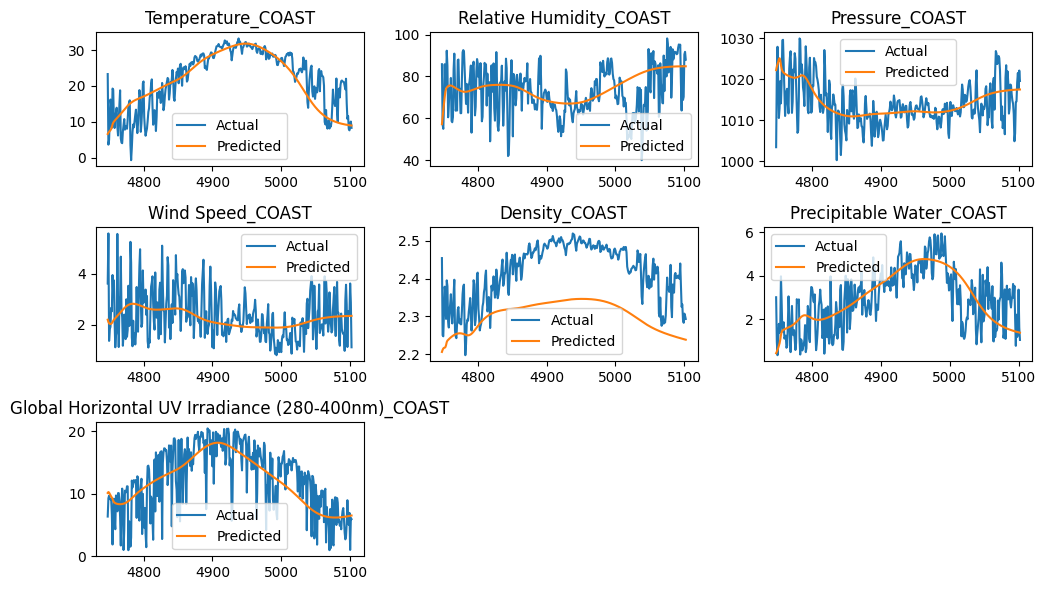

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, feature in enumerate(data.columns):
    plt.subplot(3, 3, i+1)
    plt.plot(test.index[:len(predictions)], test[feature][:len(predictions)], label='Actual')
    plt.plot(test.index[:len(predictions)], predictions[:,i], label='Predicted')
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.show()